In [47]:
%cd ../../..

/home/jupyter/work/resources/nlp-coursework


In [107]:
from src.nlp.application import (Pipeline, 
                                 get_df_by_film_and_person, 
                                 get_df_by_person, 
                                 collect_sents_to_summarize,
                                 split_opinions_to_chunks)
from datasets_ import DatasetLoader

import dill
from tqdm.notebook import tqdm
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib notebook
from wordcloud import WordCloud


from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline
from transformers import MBartTokenizer, MBartForConditionalGeneration
from transformers import AutoTokenizer, T5ForConditionalGeneration
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers.pipelines.question_answering import QuestionAnsweringPipeline

import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

import warnings
warnings.filterwarnings("ignore")

import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Execute error: Failed to allocate servant c1.4: internal error. Please try again

In [49]:
data = DatasetLoader.load_named_entities_dataset(show_path=True)
data

/home/jupyter/work/resources/nlp-coursework/data/named_entities.csv


,ne,occurrences,film_id,n_sents
0,Кинг,[Несколько лет назад прочитала оригинальный ро...,435,150
1,Дарабонт,[После взросления и прочтения книги фильм Дара...,435,65
2,Перси,[Особенно нелепа вся эта линия с травлей Перси...,435,93
3,Депрессия,"[За то, что работает по блату (во времена Депр...",435,1
4,Делакруа,"[И кстати, ради большей слезовыжималки сценари...",435,26
...,...,...,...,...
106669,Сергей Эйзенштейн,[В качестве наглядного примера могу предложить...,969760,1
106670,Ферруччо,[Молодой Ферруччо - типичный англо-саксонский ...,969760,9
106671,Эдуардо де Филиппо,[Авторам смотреть старые итальянские фильмы и ...,969760,1
106672,Ютюба,[И он по законам мотивашек с Ютюба читает как ...,969760,1


In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model_name = "AlexKay/xlm-roberta-large-qa-multilingual-finedtuned-ru"
model = pipeline('question-answering', model=model_name, tokenizer=model_name)

cpu


Downloading:   0%|          | 0.00/781 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.08G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/516 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [57]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

model_name = "AlexKay/xlm-roberta-large-qa-multilingual-finedtuned-ru"
model = pipeline('question-answering', model=model_name, tokenizer=model_name, device=0)

cuda:0


Downloading:   0%|          | 0.00/781 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.08G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/516 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [96]:
#!g1.1
def get_person_characteristics(data: pd.DataFrame, 
                               name: str, 
                               model: QuestionAnsweringPipeline,
                               film_id: int = None,
                               ):
    from src.nlp.preprocessing import clean
    from random import shuffle
    import numpy as np
    
    _N_SENTS = 100
    
    if film_id is not None:
        listed_opinions = collect_sents_to_summarize(
            get_df_by_film_and_person(data, film_id, name), 
            n_sents = _N_SENTS
        )
    else:
        listed_opinions = collect_sents_to_summarize(
            get_df_by_person(data, name), 
            n_sents = _N_SENTS
        )       
    
    opinions = '\n'.join(listed_opinions)
#     print(opinions, end='\n------------------------------------\n')
    opinions = clean(opinions, char_clean_only=True, lowercase=False)
#     print(opinions)
    
    answers = []
    scores = []
  

    try:
        while True:
            questions = [
                {
                    'question': f'Какая {name}?',
                    'context': opinions
                },
                {
                    'question': f'Что сделала {name}?',
                    'context': opinions
                },
                {
                    'question': f'Что хорошо у {name}?',
                    'context': opinions
                },
                {
                    'question': f'Что плохо у {name}?',
                    'context': opinions
                }                
            ]
            
            for question in questions:
                answer = model(question)
                print(answer, end='\n\n')
                opinions = opinions.replace(answer['answer'], ' ')
                answers.append(answer['answer'])
                scores.append(answer['score'])

    except KeyboardInterrupt:
        pass
    finally:
        return np.array(scores), np.array(answers)
        
        

In [90]:
#!g1.1
scores, answers = get_person_characteristics(data, 'Хэтэуэй', model)

{'score': 0.686664879322052, 'start': 5516, 'end': 5536, 'answer': ' прекрасная актриса,'}

{'score': 0.5645750164985657, 'start': 6473, 'end': 6508, 'answer': ' отлично отыграла своего персонажа,'}

{'score': 0.3694474995136261, 'start': 11617, 'end': 11652, 'answer': ' свежа, очаровательна и убедительна'}

{'score': 0.3420935869216919, 'start': 12963, 'end': 12983, 'answer': ' стала Селиной Кайл.'}

{'score': 0.4906530976295471, 'start': 12358, 'end': 12378, 'answer': ' Потрясающая, милая,'}

{'score': 0.34241214394569397, 'start': 16342, 'end': 16356, 'answer': ' делает выбор,'}

{'score': 0.327901154756546, 'start': 8010, 'end': 8039, 'answer': ' невероятно красивая женщина.'}

{'score': 0.28490975499153137, 'start': 6804, 'end': 6818, 'answer': ' Неплохую игру'}

{'score': 0.475708544254303, 'start': 14934, 'end': 14944, 'answer': ' милая Энн'}

{'score': 0.15502893924713135, 'start': 2470, 'end': 2529, 'answer': ' занималась физическими упражнениями по пять дней в неделю,'}

{'sc

the ndarray.
  tensor = as_tensor(value)
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:705: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:705: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:705: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuple

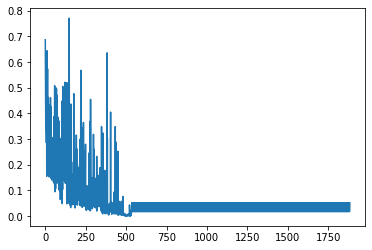

In [91]:
#!g1.1
plt.plot(scores)

In [92]:
#!g1.1
clean_answers = list(map(lambda s: s.strip(' .,:'), answers))

In [97]:
#!g1.1
clean_answers = np.array(clean_answers)
scores = np.array(scores)

In [98]:
#!g1.1
clean_answers = clean_answers[scores > 0.18]

In [99]:
#!g1.1
clean_answers

array(['прекрасная актриса', 'отлично отыграла своего персонажа',
       'свежа, очаровательна и убедительна', 'стала Селиной Кайл',
       'Потрясающая, милая', 'делает выбор',
       'невероятно красивая женщина', 'Неплохую игру', 'милая Энн',
       'своенравная, дерзкая, гордая и опасная',
       'изучала танцы и разные трюки', 'одной из моих любимых актрис',
       'играла с переменным успехом', 'обычной обаятельной девушки',
       'прекрасно справилась с этой ролью',
       'красивая, сексуальная и убедительная', 'актерскую игру',
       'милая, обаятельная и мечтательная Белая Королева',
       'задача заключалась воплотить на экране Белую Королеву',
       'моя любимая актриса', 'превзошла саму себя', 'Андреа',
       'интересную героиню', 'создав живого, привлекательного персонажа',
       'Красавица', 'с ролью она определенно справилась',
       'это девушка, которая может покорить любого парня своим только взглядом',
       'великолепно справилась со своей ролью', 'она неве

In [106]:
#!g1.1
import dill

with open('data/wordcloud/scores.np', 'wb') as f:
    dill.dump(scores[scores > 0.18], f)
with open('data/wordcloud/clean_answers.np', 'wb') as f:
    dill.dump(clean_answers, f)

In [ ]:
#!g1.1


In [ ]:
#!g1.1


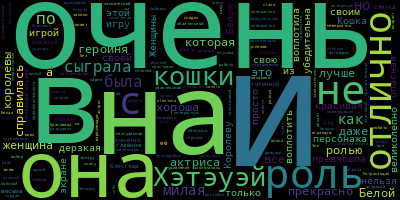

In [100]:
#!g1.1
wc = WordCloud().generate(' '.join(clean_answers))
wc.to_image()